# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [22]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler, Normalizer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
import time

In [23]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Access and Gathering data

In [24]:
df_sparkify = spark.read.json('mini_sparkify_event_data.json')
df_sparkify.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [25]:
df_sparkify.count()

286500

In [26]:
df_sparkify.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

### The data is not clean so I need to clean it a bit.

#### Drop wrong value
Check null values in the table

In [27]:
exprs = [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_sparkify.columns]
result = df_sparkify.agg(*exprs)

result.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



The ```userId``` and ```sessionId``` columns do not include any null values, yet a large number of null values are present in other columns.

Empty checking

In [28]:
df_sparkify.filter(df_sparkify['userId']=='').count()

8346

In [29]:
df_sparkify.filter(df_sparkify['sessionId']=='').count()

0

Eliminate incorrect values from the table.

In [30]:
df_clean = df_sparkify.filter(df_sparkify['userId']!='')

In [31]:
exprs = [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_clean.columns]
result = df_clean.agg(*exprs)

result.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



The ```artists```, ```length```, and ```song``` variables all have null values that are present in the same records. I won't delete these recordings since they may be linked to user activities even in the absence of music being played.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [32]:
#create new columns "Churn" and "Downgrade"
df_sparkify = df_sparkify.withColumn("Churn", F.expr("CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END"))
df_sparkify = df_sparkify.withColumn("Downgrade", F.expr("CASE WHEN page = 'Submit Downgrade' THEN 1 ELSE 0 END"))

In [33]:
#Define window bounds for churn
window_churn = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df_sparkify = df_sparkify.withColumn("total_churn", F.sum("Churn").over(window_churn))
#Define window bounds for downgrade 
window_downgrade = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df_sparkify = df_sparkify.withColumn("total_downgrade", F.sum("Downgrade").over(window_downgrade))

In [34]:
df_sparkify.filter(F.col("Churn") == 1).sort("total_churn", ascending=False).show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+---------+-----------+---------------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|Churn|Downgrade|total_churn|total_downgrade|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+---------+-----------+---------------+
|  null|Cancelled|    Mason|     M|           10|    Hart|  null| free|  Corpus Christi, TX|   GET|Cancellation Conf...|1533157139000|      174|null|   200|1539318918000|"Mozilla/5.0 (Mac...|   125|    1|        0|          1|              0|
|  null|Cancelled|    Ethan|

In [35]:
df_sparkify.filter(F.col("Downgrade") == 1).sort("total_downgrade", ascending=False).show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+-----+---------+-----------+---------------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|Churn|Downgrade|total_churn|total_downgrade|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+-----+---------+-----------+---------------+
|  null|Logged In|   Payton|     F|           27|Campbell|  null| paid|Los Angeles-Long ...|   PUT|Submit Downgrade|1529027541000|     1546|null|   307|1541255372000|"Mozilla/5.0 (Win...|    39|    0|        1|          0|              3|
|  null|Logged In|   Payton|     F|         

In [36]:
df_sparkify.show(5)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+---------+-----------+---------------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|Downgrade|total_churn|total_downgrade|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+---------+-----------+---------------+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/

In [37]:
df_sparkify.groupBy("Churn").count().show()
df_sparkify.groupBy("Downgrade").count().show()

+-----+------+
|Churn| count|
+-----+------+
|    1|    52|
|    0|286448|
+-----+------+

+---------+------+
|Downgrade| count|
+---------+------+
|        1|    63|
|        0|286437|
+---------+------+



In [38]:
# Number of interactions users 
result = df_sparkify.dropDuplicates(['userId']).groupby('total_churn').agg(F.count('*').alias('count')).orderBy('total_churn')
result.show()

+-----------+-----+
|total_churn|count|
+-----------+-----+
|          0|  174|
|          1|   52|
+-----------+-----+



In [39]:
gender = df_sparkify.select("userId", 'gender', 'Churn').distinct()
df_gender = gender.groupby(['Churn', 'gender']).count().orderBy('Churn').toPandas()
x = 'Churn'
y = 'count'
orders = ["Active", "Cancelled"]

In [40]:
df_gender.head(5)

,Churn,gender,count
0,0,M,121
1,0,F,104
2,0,None,1
3,1,F,20
4,1,M,32


In [41]:
df_gender.dropna()

,Churn,gender,count
0,0,M,121
1,0,F,104
3,1,F,20
4,1,M,32


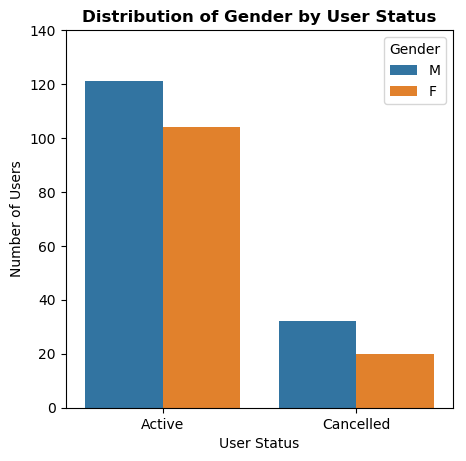

In [62]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
sns.barplot(data=df_gender, x=x, y=y, hue='gender')
plt.ylim([0, 140])
plt.title("Distribution of Gender by User Status", fontweight='bold')
plt.xlabel("User Status")
plt.ylabel("Number of Users")
plt.xticks(range(len(orders)), orders)
plt.legend(title='Gender')
plt.show()

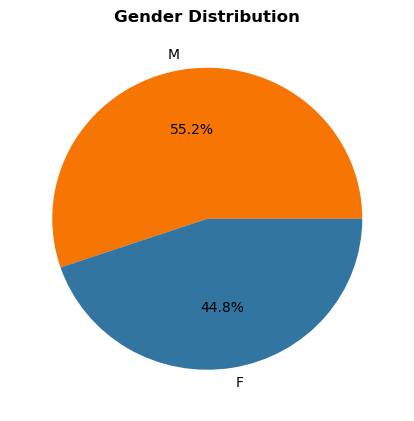

In [63]:
df_gender_count = gender.select('gender').toPandas()
# Count the number of each gender
gender_counts = df_gender_count['gender'].value_counts()
# Create a pie chart
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
colors = ["#f77502", "#3275a1"]
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=colors)
plt.title("Gender Distribution", fontweight='bold')
plt.show()

In [67]:
level = df_sparkify.select('userId', 'level', 'Churn').distinct()

In [68]:
df_level = level.groupby(['Churn', 'level']).count().sort('Churn').toPandas()
x = 'Churn'
y = 'count'
orders = ["Active","Cancelled"]

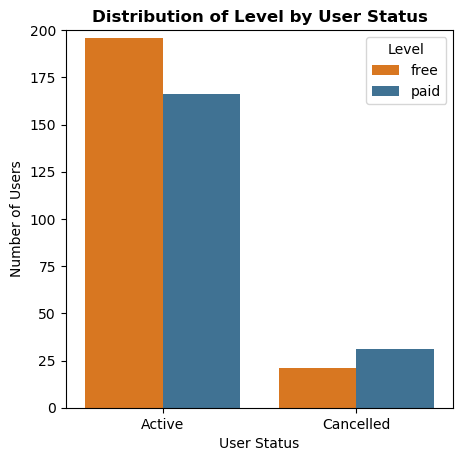

In [69]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# Create the bar plot
sns.barplot(x=x, y=y, hue='level', data=df_level, palette=["#f77502", "#3275a1"])
# Customize the plot
plt.ylim([0, 200])
plt.title("Distribution of Level by User Status", fontweight='bold')
plt.xlabel("User Status")
plt.ylabel("Number of Users")
plt.xticks(range(len(orders)), orders)
plt.legend(title='Level')

plt.show()

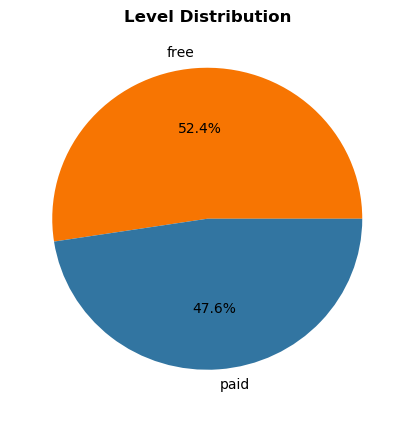

In [72]:
df_level_count = level.select('level').toPandas()
# Count the number of each gender
level_counts = df_level_count['level'].value_counts()
# Create a pie chart
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
colors = ["#f77502", "#3275a1"]
plt.pie(level_counts, labels=level_counts.index, autopct='%1.1f%%', colors=colors)
plt.title("Level Distribution", fontweight='bold')
plt.show()

#### Top 10 artist have most played song

In [75]:
top10_artists = df_sparkify.select('artist').toPandas()['artist'].tolist()

In [77]:
pd_artist = df_sparkify.toPandas()

In [78]:
pd_artist['artist'].value_counts()[:10]

Kings Of Leon             1841
Coldplay                  1813
Florence + The Machine    1236
Dwight Yoakam             1135
BjÃÂ¶rk                  1133
The Black Keys            1125
Muse                      1090
Justin Bieber             1044
Jack Johnson              1007
Eminem                     953
Name: artist, dtype: int64

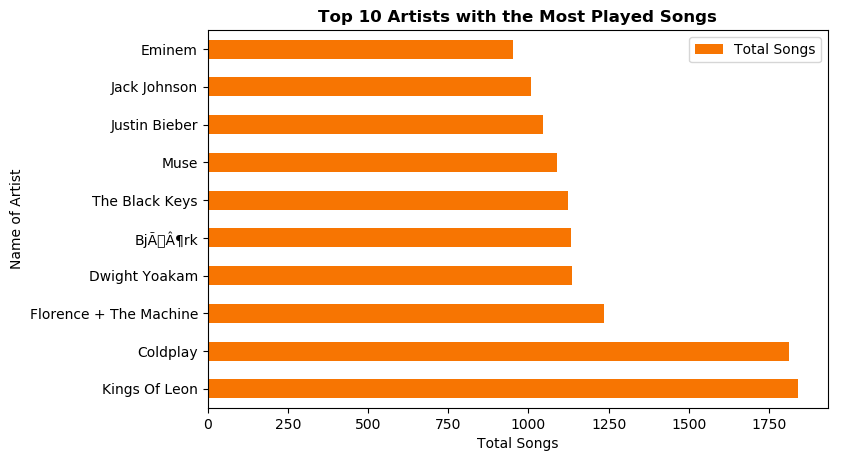

In [81]:
# Get the top 10 artists with the most played songs
top_10_artists = pd_artist['artist'].value_counts()[:10]
# Create a DataFrame with the top 10 artists and their counts
top_10_df = pd.DataFrame({'Artist': top_10_artists.index, 'Total Songs': top_10_artists.values})
# Create a stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
colors = ['#f77502', '#3275a1', '#FF9900', '#3366CC', '#FFCC00', '#0099CC', '#FFFF00', '#6699CC', '#FF6633', '#66CC00']
top_10_df.plot(kind='barh', x='Artist', stacked=True, color=colors, ax=ax)
plt.title('Top 10 Artists with the Most Played Songs', fontweight='bold')
plt.xlabel('Total Songs')
plt.ylabel('Name of Artist')
plt.show()

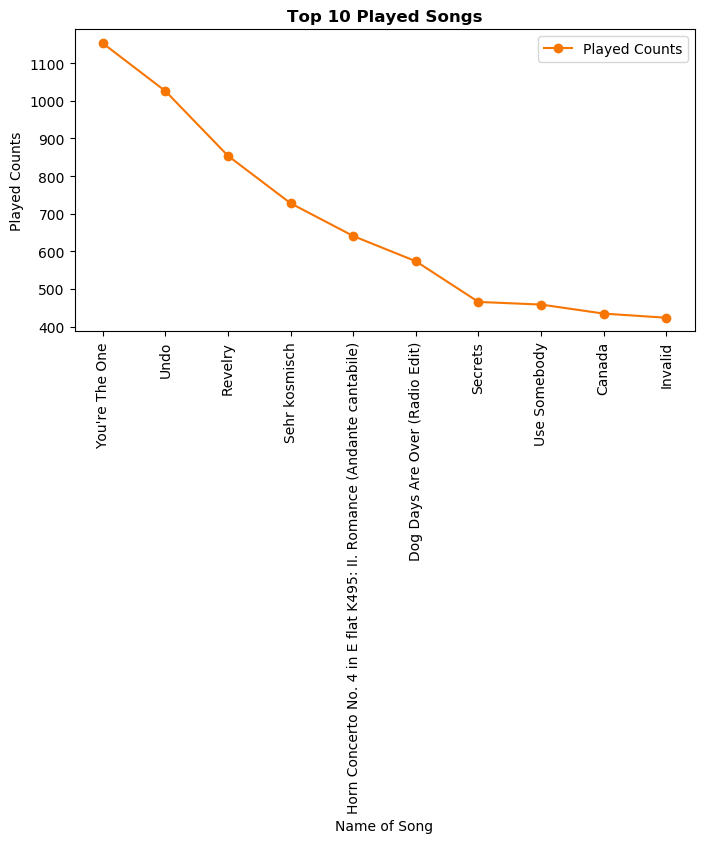

In [99]:
# Get the top 10 played songs
top_10_songs = pd_artist['song'].value_counts()[:10]

# Create a DataFrame with the top 10 played songs and their counts
top_10_df = pd.DataFrame({'Song': top_10_songs.index, 'Played Counts': top_10_songs.values})

# Create a line chart
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
top_10_df.plot(kind='line', x='Song', y='Played Counts', ax=ax, marker='o', color='#f77502')

plt.title('Top 10 Played Songs', fontweight='bold')
plt.xlabel('Name of Song')
plt.ylabel('Played Counts')

# Manually set the x-axis labels
plt.xticks(range(len(top_10_df['Song'])), top_10_df['Song'], rotation=90)

plt.show()


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [103]:
# Select the relevant columns
df_feature = df_sparkify.select(
    'userId', 'level', 'gender', 'Churn', 'ts', 'length', 'artist', 'song', 'page'
)

# Define the aggregation expressions
aggregations = [
    F.avg('length').alias('avg_song_length'),
    F.countDistinct('artist').alias('total_artist'),
    F.countDistinct('song').alias('total_song'),
    F.count('page').alias('total_session'),
    F.sum(F.when(F.col('page') == 'Thumbs Up', 1).otherwise(0)).alias('total_thumb_up'),
    F.sum(F.when(F.col('page') == 'Thumbs Down', 1).otherwise(0)).alias('total_thumb_down'),
    F.sum(F.when(F.col('page') == 'Add Friend', 1).otherwise(0)).alias('total_add_friend'),
    F.sum(F.when(F.col('page') == 'Add to Playlist', 1).otherwise(0)).alias('total_add_playlist')
]

# Apply the aggregations using groupBy and agg
df_user = df_feature.groupBy('userId').agg(*aggregations)

df_user.show(5)


+------+------------------+------------+----------+-------------+--------------+----------------+----------------+------------------+
|userId|   avg_song_length|total_artist|total_song|total_session|total_thumb_up|total_thumb_down|total_add_friend|total_add_playlist|
+------+------------------+------------+----------+-------------+--------------+----------------+----------------+------------------+
|100010|  243.421444909091|         252|       269|          381|            17|               5|               4|                 7|
|200002|242.91699209302305|         339|       378|          474|            21|               6|               4|                 8|
|   125|261.13913750000006|           8|         8|           11|             0|               0|               0|                 0|
|   124|248.17653659965674|        2232|      3339|         4825|           171|              41|              74|               118|
|    51|247.88055082899118|        1385|      1854|         24

In [104]:
label = df_sparkify.select('userId', F.col('total_churn').alias('label')).dropDuplicates()

In [105]:
# join the features and label
data = df_user.join(label, "userId").drop("userId")

In [106]:
data = data.dropna()
data_final = data.toPandas()

In [107]:
data_final.columns

Index(['avg_song_length', 'total_artist', 'total_song', 'total_session',
       'total_thumb_up', 'total_thumb_down', 'total_add_friend',
       'total_add_playlist', 'label'],
      dtype='object')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


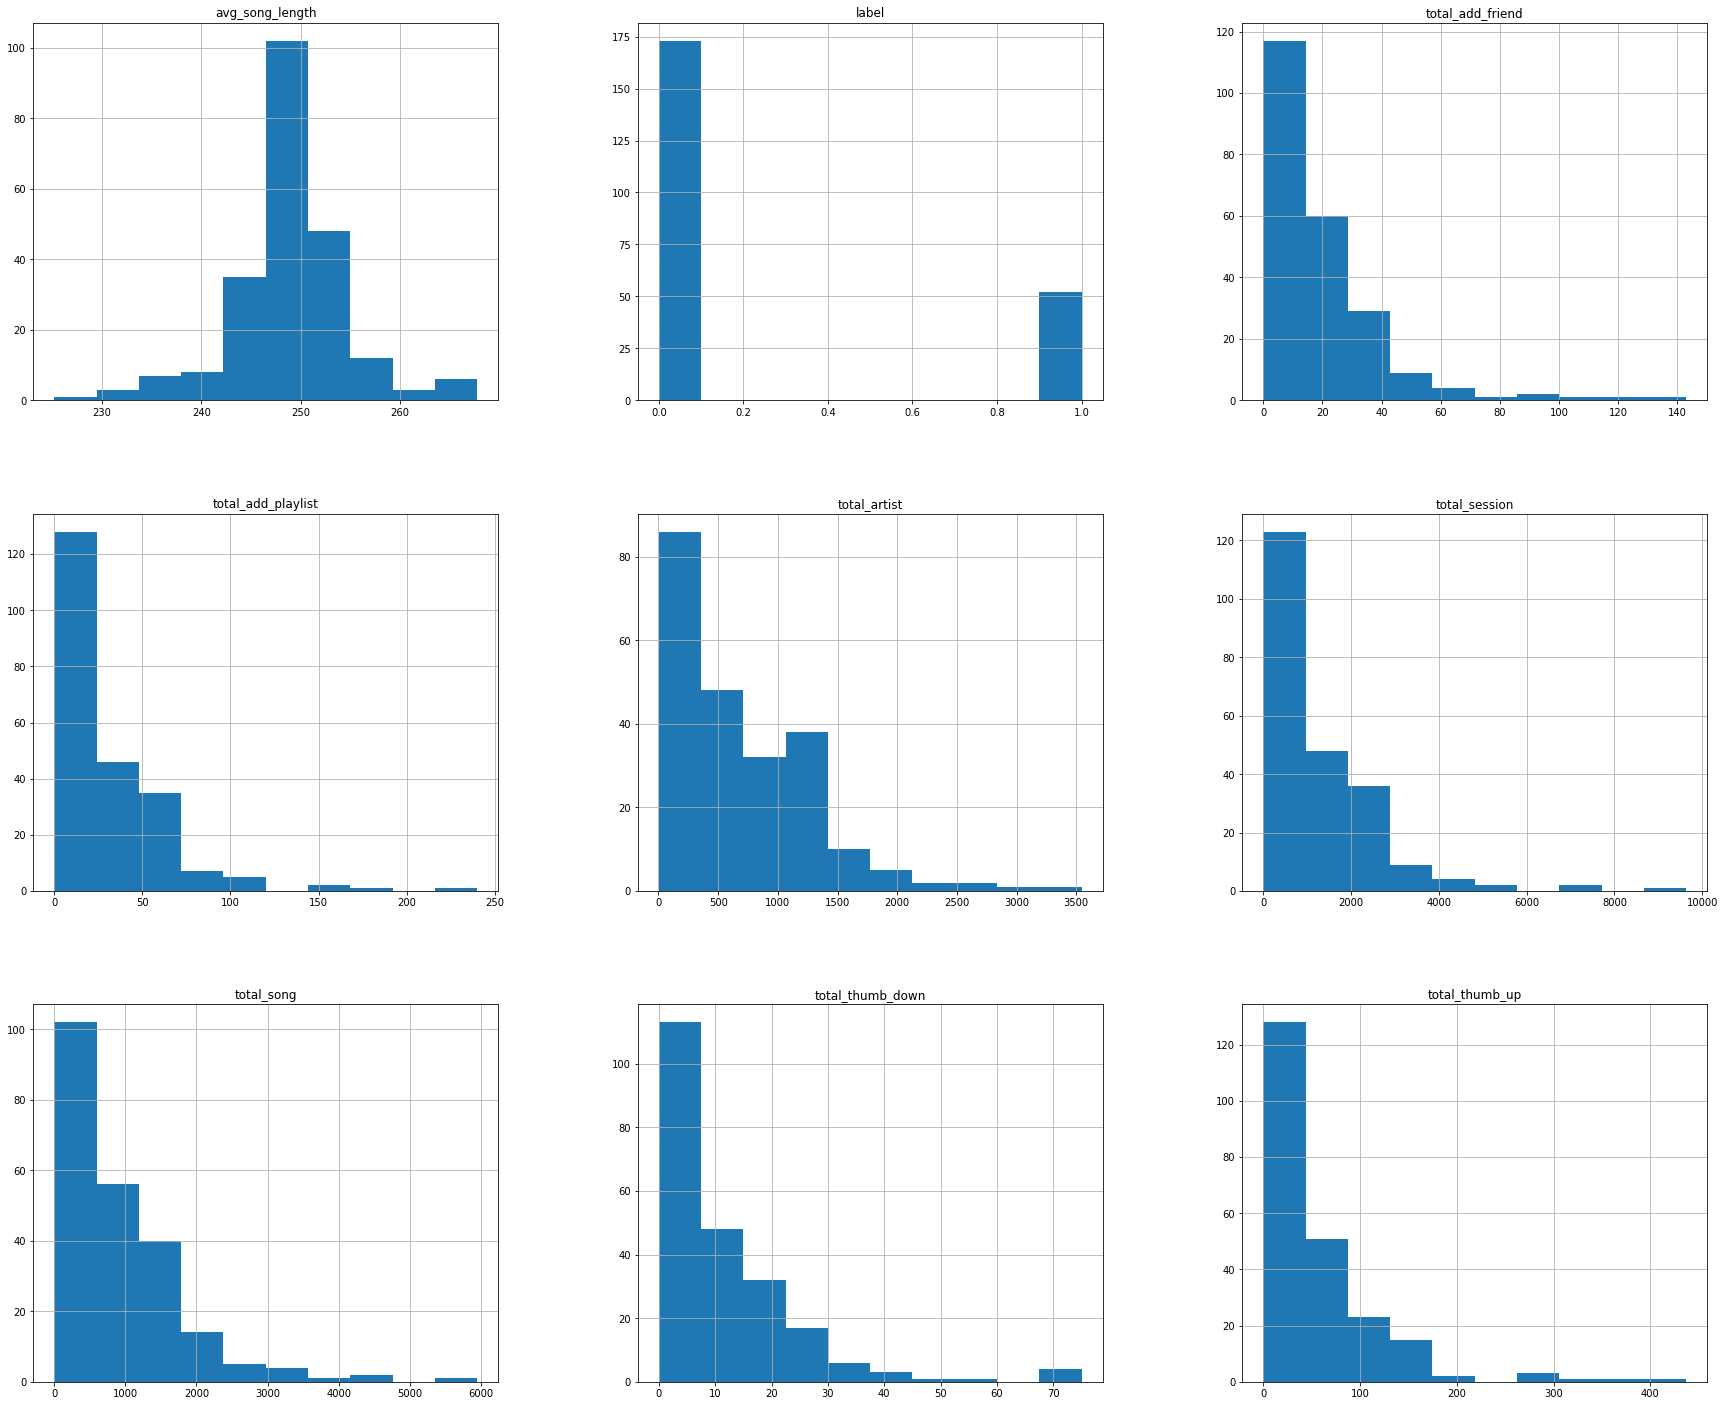

In [108]:
fig = plt.figure(figsize=(30, 25))
ax = fig.gca()
h = data_final.hist(ax=ax)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [109]:
feature_col = data.columns
feature_col.remove("label")

In [110]:
# split the data to 80% training and 20% testing, set random seed to 42.
train, test = data.randomSplit([0.8, 0.2], seed=42)

In [111]:
test.count()

34

In [112]:
def build_model(classifier, param):
    """
    Build the classification model with Cross Validation
    
    Parameters:
    classifier: Model
    param: parameter tuning for the model
    
    Returns:
    Classification model
    """
    # Define the stages of the pipeline
    assembler = VectorAssembler(inputCols=feature_col, outputCol="features_vec")
    scaler = Normalizer(inputCol="features_vec", outputCol="features")
    
    # Create the pipeline with the specified classifier
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    # Create a CrossValidator model
    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='label', metricName='f1'),
        numFolds=5,
    )
    return model


In [113]:
def evaluate_model(pred):
    """ Model evaluation with F1 score metric """
    
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    f1_score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    print('F1 score: {}'.format(f1_score))

#### Random Forest

In [114]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
rf_param = ParamGridBuilder().build()
rf_model = build_model(rf, rf_param)

In [115]:
start_time = time.time()
rf_fit_model = rf_model.fit(train)
print("Train time:", time.time() - start_time)

Train time: 349.82930183410645


In [116]:
rf_pred = rf_fit_model.transform(test)

In [117]:
evaluate_model(rf_pred)

F1 score: 0.6289592760180995


#### Gradient Boosting

In [118]:
gbt = GBTClassifier(featuresCol="features", labelCol="label")
gbt_param = ParamGridBuilder().build()
gbt_model = build_model(gbt, gbt_param)

In [119]:
start_time = time.time()
gbt_fit_model = gbt_model.fit(train)
print("Train time:", time.time() - start_time)

Train time: 1147.3311548233032


In [120]:
gbt_pred = gbt_fit_model.transform(test)

In [121]:
evaluate_model(gbt_pred)

F1 score: 0.7793562708102109


#### Logistic Regression

In [122]:
logreg = LogisticRegression(featuresCol="features", labelCol="label")
logreg_param = ParamGridBuilder().build()
logreg_model = build_model(logreg, logreg_param)

In [123]:
start_time = time.time()
logreg_fit_model = logreg_model.fit(train)
print("Train time:", time.time() - start_time)

Train time: 617.7495164871216


In [124]:
pred = logreg_fit_model.transform(test)

In [125]:
evaluate_model(pred)

F1 score: 0.6289592760180995


#### Reference

- https://arize.com/blog-course/f1-score/
- https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html
- https://www.tensorflow.org/guide/keras/training_with_built_in_methods
- https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.sql.DataFrame.randomSplit.html
- https://datatofish.com/line-chart-python-matplotlib/
- https://www.researchgate.net/figure/Confusion-matrix-Precision-Recall-Accuracy-and-F1-score_fig4_367393140

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.